In [1]:
# Cell 1: ライブラリのインポートとモデル定義
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import warnings
import time
import tqdm
import matplotlib.pyplot as plt

# PyTorchの警告を無視 (開発時は非推奨ですが、Notebookでの実行をスムーズにするため)
warnings.filterwarnings("ignore")

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cuda


In [2]:
# --- 定義されたモデルクラス (Binary_classification) ---
class Binary_classification(nn.Module):
    # NOTE: super()の引数を修正: super(Binary_classification_v2, self).__init__() -> super(Binary_classification, self).__init__()
    def __init__(self, latent, input_depth, input_height, input_width):
        super(Binary_classification, self).__init__()
        
        # モデル構造の定義
        self.features = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(True),
            
            nn.Conv3d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(True),
            
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(True),

            nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(True),
            
            nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True)
        )

        FINAL_FLATTEN_SIZE = 16 * 5 * 23 * 23 # 仮の値
        
        # --- 分類ヘッド ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(FINAL_FLATTEN_SIZE, latent),
            nn.ReLU(True), 

            nn.Linear(latent, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [3]:
temp_model = Binary_classification(latent=100, input_depth=30, input_height=100, input_width=100) 
dummy_input = torch.randn(1, 1, 30, 100, 100) 

# 特徴抽出層まで実行
output_features = temp_model.features(dummy_input)

# 結果のサイズを確認
print(output_features.size())

torch.Size([1, 16, 5, 23, 23])


In [4]:
class DataSet:
    def __init__(self, data, label):
        self.label = label
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, path, patience=10, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            # self.flog.write(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    
    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
            # self.flog.write(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [6]:
bubble_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/data/Binary_data/processed_data/slide_bubble.npy")
removal_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/data/Binary_data/processed_data/all_data_after_bubble_removal.npy")

# バブルのラベルは1、非バブルのラベルは0
bubble_label = [1] * len(bubble_data)
removal_label = [0] * len(removal_data)

In [7]:
# print(len(bubble_data))
# print(len(removal_data))
# print(bubble_label)
# print(removal_label)

In [8]:
data = np.concatenate((bubble_data, removal_data))
label = np.concatenate((bubble_label, removal_label))

In [9]:
len(data)

5659

In [10]:
# data = torch.from_numpy(data).float()
train_data, val_data, train_labels, val_labels = train_test_split(
    data, label, test_size=0.2, random_state=42, stratify=label
)
val_data, test_data, val_labels, test_labels = train_test_split(
    val_data, val_labels, test_size=0.25, random_state=42, stratify=val_labels
)

# train_data = augment_data(train_data, augment_horizontal, augment_vertical, augment_velocity_axis)
# train_labels     = [0] * len(train_data)

train_dataset    = DataSet(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset      = DataSet(val_data, val_labels)
val_dataloader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
dataloader_dic   = {"train": train_dataloader, "val": val_dataloader}


# train_dataset = DataSet(train_data, train_labels)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_dataset = DataSet(val_data, val_labels)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# dataloader_dic = {"train": train_dataloader, "val": val_dataloader}

In [11]:
print(849//16)
print(849%16)

53
1


In [12]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

4527
849
283


In [13]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [14]:
model = Binary_classification(latent=100, input_depth=30, input_height=100, input_width=100)
model.apply(weights_init)
model.to(device)

Binary_classification(
  (features): Sequential(
    (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (10): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (13): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(st

In [15]:
optimizer = optim.AdamW(
        model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False
    )
criterion = nn.BCEWithLogitsLoss()

In [16]:
early_stopping = EarlyStopping(patience=50, verbose=True, path="/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Cygnus-X_cloud/Binary_classification/savedir/model_parameter.pth")

In [17]:
train_loss_list = []

val_loss_list = []
val_accuracy_list = []
val_recall_list = []

best_val_loss = float('inf')
start = time.time()
num_epochs = 1000


for epoch in range(num_epochs):
    train_loss_num = 0
    val_loss_num = 0

    # 精度計算のためのカウンター
    val_correct_preds = 0
    val_total_samples = 0

    val_true_positives = 0
    val_actual_positives = 0 # (TP + FN)

    for phase in ["train", "val"]:
        dataloader = dataloader_dic[phase]
        if phase == "train":
            model.train()  # モデルを訓練モードに
        else:
            model.eval()

        for images, labels in tqdm.tqdm(dataloader):
            images = images.view(-1, 1, 30, 100, 100)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):

                # モデルの出力を計算する
                output = model(images.clone().float().to(device))
                # print(output)
                # print(labels)
                # 損失を計算する
                loss = criterion(output.to("cpu"), labels.to("cpu"))
                weighted_loss = torch.mean(loss)

                if phase == "val":
                    # Sigmoid出力 (output) を使用し、0.5を閾値として予測
                    # outputは [B, 1]、labels_deviceは [B, 1]
                    predicted = (output > 0.5).float()
                    
                    # 1. 精度 (Accuracy) の計算
                    val_correct_preds += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)
                    
                    # 2. Recallの計算
                    # a. True Positives (TP): predicted=1 かつ actual=1
                    val_true_positives += ((predicted == 1) & (labels == 1)).sum().item()
                    
                    # b. Actual Positives (TP + FN): actual=1 (正解ラベルが1の総数)
                    val_actual_positives += (labels == 1).sum().item()
                
                # パラメータの更新
                if phase == "train":
                    weighted_loss.backward()
                    optimizer.step()
                    train_loss_num += weighted_loss.item()
                else:
                    val_loss_num += weighted_loss.item()
                    
        # エポック終了後の検証精度の計算
        val_accuracy = val_correct_preds / val_total_samples if val_total_samples > 0 else 0.0
        
        # ⭐ 検証再現率 (Recall) の計算 ⭐
        val_recall = val_true_positives / val_actual_positives if val_actual_positives > 0 else 0.0
        
        if phase == "train":
            train_loss_list.append(train_loss_num)
        else:
            val_loss_list.append(val_loss_num)
            val_accuracy_list.append(val_accuracy)
            val_recall_list.append(val_recall)
            
    # wandb.log({"train loss": train_loss_num, "validation loss": val_loss_num, "epoch":  epoch})
    # if val_loss_num < best_val_loss:
    #     best_val_loss = val_loss_num
        # wandb.log({"best validation loss": best_val_loss, "epoch":  epoch})
    
    # print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, val_loss_num))
    print("Epoch [{}/{}], Val Loss: {:.4f}, Val Accuracy: {:.4f}, Val Recall: {:.4f}".format(
        epoch + 1, num_epochs, val_loss_num, val_accuracy, val_recall # Recallを追加
    ))
    print("")
    
    early_stopping(val_loss_num, model)
    if early_stopping.early_stop:
        print("Early_Stopping")
        break

#train_loss_path = args.savedir_path + "/loss_log" + f"/train_loss_{args.wandb_name}.npy"
#val_loss_path = args.savedir_path + "/loss_log" + f"/val_loss_{args.wandb_name}.npy"

#np.save(train_loss_path, train_loss_list)
#np.save(val_loss_path, val_loss_list)

print((time.time() - start) / 60)

100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.49it/s]


Epoch [1/1000], Val Loss: 5.6152, Val Accuracy: 0.9588, Val Recall: 0.1667

Validation loss decreased (inf --> 5.615178).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.21it/s]


Epoch [2/1000], Val Loss: 3.6795, Val Accuracy: 0.9729, Val Recall: 0.4762

Validation loss decreased (5.615178 --> 3.679466).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 85.92it/s]


Epoch [3/1000], Val Loss: 3.7584, Val Accuracy: 0.9741, Val Recall: 0.5476

EarlyStopping counter: 1 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 91.59it/s]


Epoch [4/1000], Val Loss: 2.7767, Val Accuracy: 0.9776, Val Recall: 0.6429

Validation loss decreased (3.679466 --> 2.776732).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.43it/s]


Epoch [5/1000], Val Loss: 2.9480, Val Accuracy: 0.9823, Val Recall: 0.9048

EarlyStopping counter: 1 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 82.04it/s]


Epoch [6/1000], Val Loss: 2.1005, Val Accuracy: 0.9929, Val Recall: 0.8810

Validation loss decreased (2.776732 --> 2.100497).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 84.36it/s]


Epoch [7/1000], Val Loss: 1.9339, Val Accuracy: 0.9929, Val Recall: 0.8810

Validation loss decreased (2.100497 --> 1.933940).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 82.17it/s]


Epoch [8/1000], Val Loss: 1.7035, Val Accuracy: 0.9918, Val Recall: 0.8333

Validation loss decreased (1.933940 --> 1.703541).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 93.65it/s]


Epoch [9/1000], Val Loss: 1.3211, Val Accuracy: 0.9941, Val Recall: 0.9048

Validation loss decreased (1.703541 --> 1.321090).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 98.55it/s]


Epoch [10/1000], Val Loss: 2.1868, Val Accuracy: 0.9870, Val Recall: 0.8333

EarlyStopping counter: 1 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 95.03it/s]


Epoch [11/1000], Val Loss: 2.2542, Val Accuracy: 0.9882, Val Recall: 0.8095

EarlyStopping counter: 2 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 94.75it/s]


Epoch [12/1000], Val Loss: 4.6368, Val Accuracy: 0.9788, Val Recall: 0.7857

EarlyStopping counter: 3 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 83.77it/s]


Epoch [13/1000], Val Loss: 1.5443, Val Accuracy: 0.9941, Val Recall: 0.9048

EarlyStopping counter: 4 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 84.14it/s]


Epoch [14/1000], Val Loss: 1.3425, Val Accuracy: 0.9906, Val Recall: 0.8095

EarlyStopping counter: 5 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.60it/s]


Epoch [15/1000], Val Loss: 1.8752, Val Accuracy: 0.9894, Val Recall: 0.7857

EarlyStopping counter: 6 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 85.21it/s]


Epoch [16/1000], Val Loss: 1.5987, Val Accuracy: 0.9918, Val Recall: 0.9524

EarlyStopping counter: 7 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 98.23it/s]


Epoch [17/1000], Val Loss: 2.6922, Val Accuracy: 0.9894, Val Recall: 0.7857

EarlyStopping counter: 8 out of 50


100%|███████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 100.65it/s]


Epoch [18/1000], Val Loss: 2.2058, Val Accuracy: 0.9929, Val Recall: 0.8571

EarlyStopping counter: 9 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 94.86it/s]


Epoch [19/1000], Val Loss: 1.4313, Val Accuracy: 0.9953, Val Recall: 0.9048

EarlyStopping counter: 10 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 77.28it/s]


Epoch [20/1000], Val Loss: 1.2933, Val Accuracy: 0.9953, Val Recall: 0.9286

Validation loss decreased (1.321090 --> 1.293254).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.48it/s]


Epoch [21/1000], Val Loss: 1.3869, Val Accuracy: 0.9953, Val Recall: 0.9286

EarlyStopping counter: 1 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.24it/s]


Epoch [22/1000], Val Loss: 1.4622, Val Accuracy: 0.9965, Val Recall: 0.9286

EarlyStopping counter: 2 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 84.32it/s]


Epoch [23/1000], Val Loss: 1.5427, Val Accuracy: 0.9965, Val Recall: 0.9286

EarlyStopping counter: 3 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 89.66it/s]


Epoch [24/1000], Val Loss: 1.4393, Val Accuracy: 0.9953, Val Recall: 0.9048

EarlyStopping counter: 4 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 82.86it/s]


Epoch [25/1000], Val Loss: 1.4547, Val Accuracy: 0.9965, Val Recall: 0.9286

EarlyStopping counter: 5 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 84.09it/s]


Epoch [26/1000], Val Loss: 1.5955, Val Accuracy: 0.9965, Val Recall: 0.9286

EarlyStopping counter: 6 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 98.47it/s]


Epoch [27/1000], Val Loss: 1.4681, Val Accuracy: 0.9965, Val Recall: 0.9286

EarlyStopping counter: 7 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 78.93it/s]


Epoch [28/1000], Val Loss: 1.3032, Val Accuracy: 0.9965, Val Recall: 0.9286

EarlyStopping counter: 8 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 77.75it/s]


Epoch [29/1000], Val Loss: 1.3608, Val Accuracy: 0.9965, Val Recall: 0.9286

EarlyStopping counter: 9 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 90.83it/s]


Epoch [30/1000], Val Loss: 0.8206, Val Accuracy: 0.9976, Val Recall: 0.9762

Validation loss decreased (1.293254 --> 0.820583).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 78.66it/s]


Epoch [31/1000], Val Loss: 14.2444, Val Accuracy: 0.9576, Val Recall: 0.2857

EarlyStopping counter: 1 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.97it/s]


Epoch [32/1000], Val Loss: 2.1513, Val Accuracy: 0.9906, Val Recall: 0.9286

EarlyStopping counter: 2 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 79.91it/s]


Epoch [33/1000], Val Loss: 2.4321, Val Accuracy: 0.9906, Val Recall: 0.8095

EarlyStopping counter: 3 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 82.09it/s]


Epoch [34/1000], Val Loss: 1.8535, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 4 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 83.20it/s]


Epoch [35/1000], Val Loss: 2.0591, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 5 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 88.71it/s]


Epoch [36/1000], Val Loss: 1.9401, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 6 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 83.12it/s]


Epoch [37/1000], Val Loss: 2.0866, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 7 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 94.79it/s]


Epoch [38/1000], Val Loss: 2.1650, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 8 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 84.40it/s]


Epoch [39/1000], Val Loss: 2.1674, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 9 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.25it/s]


Epoch [40/1000], Val Loss: 5.2032, Val Accuracy: 0.9859, Val Recall: 0.7143

EarlyStopping counter: 10 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 77.66it/s]


Epoch [41/1000], Val Loss: 3.5080, Val Accuracy: 0.9882, Val Recall: 0.7857

EarlyStopping counter: 11 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.91it/s]


Epoch [42/1000], Val Loss: 3.8277, Val Accuracy: 0.9859, Val Recall: 0.7143

EarlyStopping counter: 12 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.78it/s]


Epoch [43/1000], Val Loss: 1.6432, Val Accuracy: 0.9906, Val Recall: 0.8095

EarlyStopping counter: 13 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 86.66it/s]


Epoch [44/1000], Val Loss: 2.3081, Val Accuracy: 0.9882, Val Recall: 0.7619

EarlyStopping counter: 14 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 97.76it/s]


Epoch [45/1000], Val Loss: 1.7464, Val Accuracy: 0.9906, Val Recall: 0.8095

EarlyStopping counter: 15 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 92.64it/s]


Epoch [46/1000], Val Loss: 1.7938, Val Accuracy: 0.9929, Val Recall: 0.8571

EarlyStopping counter: 16 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 77.92it/s]


Epoch [47/1000], Val Loss: 1.7314, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 17 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 95.72it/s]


Epoch [48/1000], Val Loss: 1.9165, Val Accuracy: 0.9918, Val Recall: 0.8333

EarlyStopping counter: 18 out of 50


100%|███████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 102.68it/s]


Epoch [49/1000], Val Loss: 1.9217, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 19 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 96.51it/s]


Epoch [50/1000], Val Loss: 2.0999, Val Accuracy: 0.9929, Val Recall: 0.8571

EarlyStopping counter: 20 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 95.43it/s]


Epoch [51/1000], Val Loss: 1.6698, Val Accuracy: 0.9953, Val Recall: 0.9048

EarlyStopping counter: 21 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 94.27it/s]


Epoch [52/1000], Val Loss: 2.4336, Val Accuracy: 0.9929, Val Recall: 0.8571

EarlyStopping counter: 22 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 83.31it/s]


Epoch [53/1000], Val Loss: 2.5689, Val Accuracy: 0.9906, Val Recall: 0.8095

EarlyStopping counter: 23 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 79.50it/s]


Epoch [54/1000], Val Loss: 2.6493, Val Accuracy: 0.9906, Val Recall: 0.8095

EarlyStopping counter: 24 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 93.30it/s]


Epoch [55/1000], Val Loss: 2.3483, Val Accuracy: 0.9929, Val Recall: 0.8571

EarlyStopping counter: 25 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 83.66it/s]


Epoch [56/1000], Val Loss: 2.1519, Val Accuracy: 0.9965, Val Recall: 0.9286

EarlyStopping counter: 26 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 85.27it/s]


Epoch [57/1000], Val Loss: 2.5383, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 27 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.27it/s]


Epoch [58/1000], Val Loss: 17.7265, Val Accuracy: 0.9435, Val Recall: 0.8333

EarlyStopping counter: 28 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.38it/s]


Epoch [59/1000], Val Loss: 1.7653, Val Accuracy: 0.9882, Val Recall: 0.8571

EarlyStopping counter: 29 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.94it/s]


Epoch [60/1000], Val Loss: 1.2634, Val Accuracy: 0.9918, Val Recall: 0.8333

EarlyStopping counter: 30 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.37it/s]


Epoch [61/1000], Val Loss: 1.5860, Val Accuracy: 0.9953, Val Recall: 0.9286

EarlyStopping counter: 31 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 96.06it/s]


Epoch [62/1000], Val Loss: 1.6952, Val Accuracy: 0.9941, Val Recall: 0.9048

EarlyStopping counter: 32 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.24it/s]


Epoch [63/1000], Val Loss: 1.2681, Val Accuracy: 0.9953, Val Recall: 0.9286

EarlyStopping counter: 33 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.30it/s]


Epoch [64/1000], Val Loss: 1.9236, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 34 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 85.90it/s]


Epoch [65/1000], Val Loss: 2.0532, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 35 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 80.97it/s]


Epoch [66/1000], Val Loss: 2.0288, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 36 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 81.39it/s]


Epoch [67/1000], Val Loss: 2.0557, Val Accuracy: 0.9941, Val Recall: 0.8810

EarlyStopping counter: 37 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 86.42it/s]


Epoch [68/1000], Val Loss: 1.9547, Val Accuracy: 0.9953, Val Recall: 0.9048

EarlyStopping counter: 38 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 77.51it/s]


Epoch [69/1000], Val Loss: 1.8036, Val Accuracy: 0.9929, Val Recall: 0.9048

EarlyStopping counter: 39 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 83.46it/s]


Epoch [70/1000], Val Loss: 3.7043, Val Accuracy: 0.9882, Val Recall: 0.8333

EarlyStopping counter: 40 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 79.28it/s]


Epoch [71/1000], Val Loss: 2.6501, Val Accuracy: 0.9894, Val Recall: 0.8095

EarlyStopping counter: 41 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 79.90it/s]


Epoch [72/1000], Val Loss: 2.3545, Val Accuracy: 0.9953, Val Recall: 0.9286

EarlyStopping counter: 42 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 78.30it/s]


Epoch [73/1000], Val Loss: 2.1277, Val Accuracy: 0.9953, Val Recall: 0.9286

EarlyStopping counter: 43 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 89.17it/s]


Epoch [74/1000], Val Loss: 1.8169, Val Accuracy: 0.9941, Val Recall: 0.9286

EarlyStopping counter: 44 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 79.81it/s]


Epoch [75/1000], Val Loss: 2.2632, Val Accuracy: 0.9953, Val Recall: 0.9048

EarlyStopping counter: 45 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 94.89it/s]


Epoch [76/1000], Val Loss: 2.5968, Val Accuracy: 0.9953, Val Recall: 0.9048

EarlyStopping counter: 46 out of 50


100%|███████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 133.29it/s]


Epoch [77/1000], Val Loss: 2.4848, Val Accuracy: 0.9953, Val Recall: 0.9048

EarlyStopping counter: 47 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 78.39it/s]


Epoch [78/1000], Val Loss: 2.5851, Val Accuracy: 0.9941, Val Recall: 0.9048

EarlyStopping counter: 48 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 77.15it/s]


Epoch [79/1000], Val Loss: 2.4434, Val Accuracy: 0.9941, Val Recall: 0.9048

EarlyStopping counter: 49 out of 50


100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 84.19it/s]

Epoch [80/1000], Val Loss: 3.7199, Val Accuracy: 0.9882, Val Recall: 0.8810

EarlyStopping counter: 50 out of 50
Early_Stopping
6.19042044878006


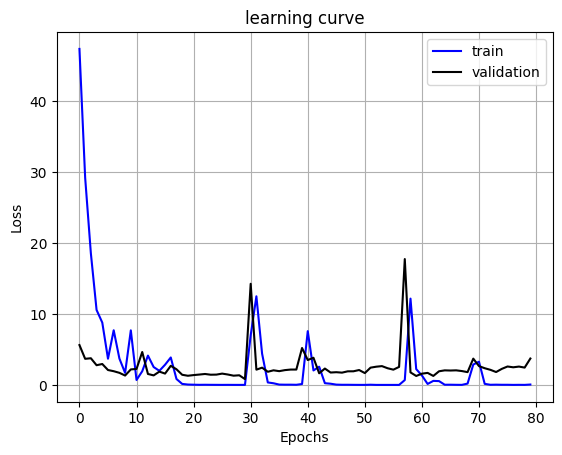

In [18]:
plt.plot(range(len(train_loss_list)), train_loss_list, "b", label="train")
plt.plot(range(len(val_loss_list)), val_loss_list, "k", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("learning curve")
plt.legend()
plt.grid()
plt.show()

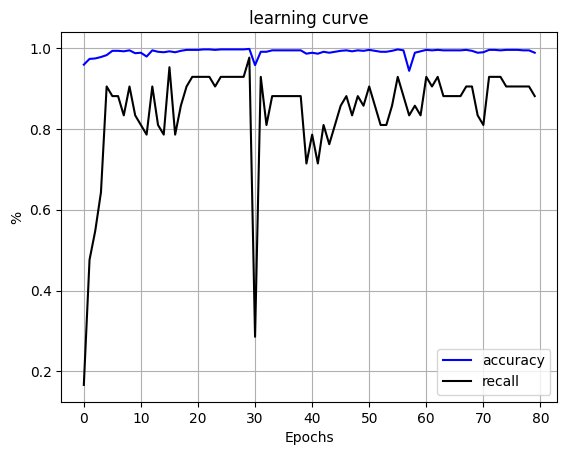

In [19]:
plt.plot(range(len(val_accuracy_list)), val_accuracy_list, "b", label="accuracy")
plt.plot(range(len(val_recall_list)), val_recall_list, "k", label="recall")
plt.xlabel("Epochs")
plt.ylabel("%")
plt.title("learning curve")
plt.legend()
plt.grid()
plt.show()

In [20]:
import math
print(math.log(0.98))

-0.020202707317519466
